# The N-body problem

### Imports

In [1]:
# Magic function: enables interactive plot
%matplotlib widget
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


### Initial conditions

In [2]:
# body mA initial conditions
mA = 1e26  # mass (kg)
rA0 = np.array([2E4, 0, 0])  # initial position (km)
vA0 = np.array([0, -10, 0])  # initial velocity (km/s)

# body mB initial conditions
mB = 1e26  # mass (kg)
rB0 = np.array([-2E4, 0, 0])  # initial position (km)
vB0 = np.array([0, 10, 0])  # initial velocity (km/s)

# body mC initial conditions
mC = 1e31  # mass (kg)
rC0 = np.array([0, 0, 0])  # initial position (km)
vC0 = np.array([0, 0, 0])  # initial velocity (km/s)

In [3]:
y0 = np.stack([
    np.stack([rA0, vA0]),
    np.stack([rB0, vB0]),
    np.stack([rC0, vC0])
])

In [4]:
masses = [mA, mB, mC]

In [5]:
y0.shape

(3, 2, 3)

In [6]:
G = 6.67259e-20  # Gravitational constant (km**3/kg/s**2)

### The derivatives


In [7]:
def n_body_eqm_derivatives(_y, t, _G, masses):
    """
    derivatives of the equations of motion describing the n-body system
    t is unused, but we keep it for consistency with scipy requirement
    """
    derivatives = []
    for i in range(_y.shape[0]):
        ri = _y[i, 0, :]
        vi = _y[i, 1, :]

        # acceleration
        ai = _G * sum([
            masses[j] * (_y[j, 0, :] - ri) / np.linalg.norm(_y[j, 0, :] - ri)**3
        for j in set(range(_y.shape[0])) - {i}
        ])
        derivatives.append(np.stack([vi, ai]))

    derivatives = np.stack(derivatives)

    return derivatives


### Forward time evolution

In [8]:
dt = 0.1  # time step (s)
tf = 1E3  # end of simulation (s)

In [9]:
def evolve(y0, tf, dt, method, params):
    history = []
    yn = y0
    t_axis = np.arange(0, tf, dt)
    for tn in t_axis:
        yn = evolve_one_step(yn, tn, dt, method, params)
        history.append(yn.copy())

    history = np.stack(history, axis=-1)
    return history

### Euler's method

In [10]:
def evolve_one_step(yn, tn, dt, method, params):
    if method == "euler":
        f = n_body_eqm_derivatives(yn, tn, *params)
        yn += f * dt
    elif method == "rk4":
        f1 = n_body_eqm_derivatives(yn, tn, *params)
        f2 = n_body_eqm_derivatives(yn + f1 * dt / 2, tn + dt / 2, *params)
        f3 = n_body_eqm_derivatives(yn + f2 * dt / 2, tn + dt / 2, *params)
        f4 = n_body_eqm_derivatives(yn + f3 * dt, tn + dt, *params)
        yn += (f1 + 2 * f2 + 2 * f3 + f4) * dt / 6

    return yn

### Running the simulation

In [11]:
history = evolve(y0, tf, dt, "rk4", params=(G, masses))

In [13]:
history.shape

(3, 2, 3, 10000)

### Plotting the outcomes

In [18]:
# Trajectories
trajectories = history[:, 0, :, ::100]
trajectories

array([[[ 1.99999999e+04,  1.99989364e+04,  1.99957876e+04,
          1.99905531e+04,  1.99832320e+04,  1.99738235e+04,
          1.99623263e+04,  1.99487389e+04,  1.99330594e+04,
          1.99152857e+04,  1.98954154e+04,  1.98734459e+04,
          1.98493742e+04,  1.98231971e+04,  1.97949109e+04,
          1.97645119e+04,  1.97319958e+04,  1.96973584e+04,
          1.96605947e+04,  1.96216998e+04,  1.95806683e+04,
          1.95374944e+04,  1.94921723e+04,  1.94446955e+04,
          1.93950574e+04,  1.93432510e+04,  1.92892690e+04,
          1.92331036e+04,  1.91747469e+04,  1.91141904e+04,
          1.90514254e+04,  1.89864428e+04,  1.89192330e+04,
          1.88497861e+04,  1.87780919e+04,  1.87041396e+04,
          1.86279182e+04,  1.85494160e+04,  1.84686211e+04,
          1.83855211e+04,  1.83001031e+04,  1.82123538e+04,
          1.81222594e+04,  1.80298055e+04,  1.79349773e+04,
          1.78377595e+04,  1.77381362e+04,  1.76360910e+04,
          1.75316070e+04,  1.74246665e+0

In [15]:
def compute_relative_marker_size(m, max_m):
    return 30 - 3*(np.log10(max_m) - np.log10(m))

(3, 3, 100)


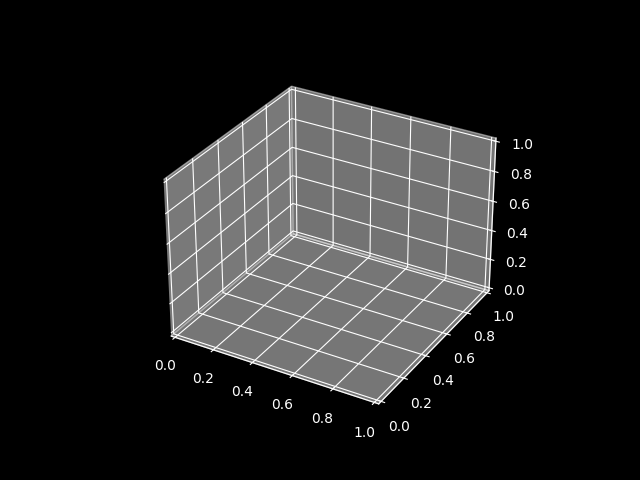

In [17]:
plt.style.use('dark_background')

fig = plt.figure()
ax = plt.axes(projection='3d')
colors = mpl.colormaps["Set3"].colors
marker_sizes = [compute_relative_marker_size(m, max(masses)) for m in masses]

print(trajectories.shape)

xm = np.min(trajectories[:, 0, :])
xM = np.max(trajectories[:, 0, :])
ym = np.min(trajectories[:, 1, :])
yM = np.max(trajectories[:, 1, :])
zm = np.min(trajectories[:, 2, :])
zM = np.max(trajectories[:, 2, :])

def animate(frame_num):
    ax.clear()
    ax.set(xlim3d=(xm, xM), xlabel="X")
    ax.set(ylim3d=(ym, yM), xlabel="Y")
    ax.set(zlim3d=(zm, zM), xlabel="Z")

    for i in range(trajectories.shape[0]):
        color=np.array(colors[i]).reshape(1, -1)
        ax.plot3D(
            trajectories[i, 0, :frame_num],
            trajectories[i, 1, :frame_num],
            trajectories[i, 2, :frame_num],
            c=color,
        )
        ax.scatter(
            trajectories[i, 0, frame_num],
            trajectories[i, 1, frame_num],
            trajectories[i, 2, frame_num],
            c=color,
            marker='o',
            s=marker_sizes[i]
        )

anim = FuncAnimation(fig, animate, frames=trajectories.shape[-1], interval=100, repeat=False)
plt.show()